# 캘리포니아 인구 조사 데이터를 활용한 캘리포니아의 주택 가격 모델링

In [1]:
# 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'Malgun Gothic'  # 'NanumGothic' 폰트 사용
plt.rcParams['axes.unicode_minus'] = False   # 마이너스 기호 깨짐 방지

## 1. 데이터 다운로드

In [2]:
# 데이터 추출 및 로드 함수
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

## 2. 데이터 구조 훑어보기

In [3]:
# 데이터프레임의 5개의 행 확인
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# 데이터프레임의 간략한 설명
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
# 카테고리별 count 확인
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
# 숫자형 특성의 요약 정보
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


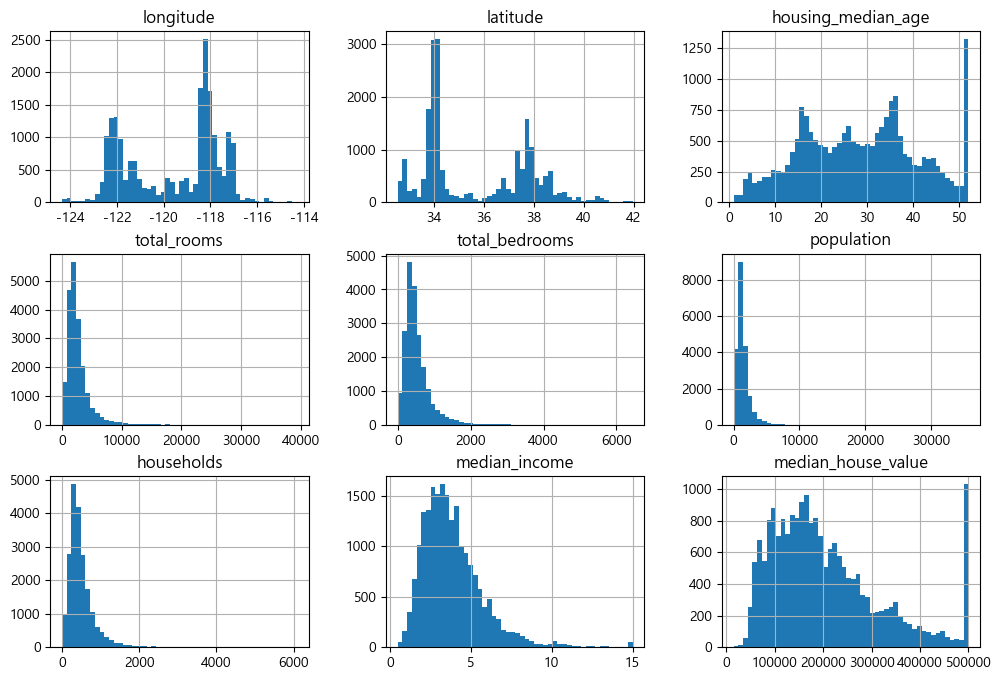

In [7]:
# 숫자형 특성 히스토그램
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(12, 8))   # 히스토그램을 50개의 구간으로 설정, 히스토그램의 크기를 가로 12인치, 세로 8인치로 설정
plt.show()

## 3. 테스트 세트 만들기

In [8]:
# 랜덤으로 샘플을 선택하여 test dataset 만들기
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))   # data의 길이만큼 숫자를 생성한 후, 그 숫자들을 무작위로 섞은 배열을 반환
                                                          # ex) len(data) = 5라면 [0, 1, 2, 3, 4] --무작위로 섞기--> [4, 1, 3, 0, 2]
    test_set_size = int(len(data) * test_ratio)   # test set 크기 설정
    test_indices = shuffled_indices[:test_set_size]   # 처음부터 test_set_size 만큼을 test set의 index로 사용
    train_indices = shuffled_indices[test_set_size:]   # 나머지 index들은 train set의 index
    return data.iloc[train_indices], data.iloc[test_indices]   # train set, test set 반환

In [9]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)

print(f"len(train_set): {len(train_set)} \nlen(test_set): {len(test_set)}")

len(train_set): 16512 
len(test_set): 4128


In [10]:
# 해시 함수를 이용해 데이터의 특정 ID 값을 기준으로 train/test dataset을 분할하는 함수
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2 ** 32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
# 행의 index를 ID로 이용하여 train/test dataset을 분할
housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")   # 기존 인덱스를 초기화 및새로운 열로 추가

In [12]:
# 위도+경도를 ID로 이용하여 train/test dataset을 분할
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [13]:
# train_test_split()을 이용하여 train/test dataset 분할
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [14]:
# pd.cut()을 이용하여 카테고리 5개로 나뉜 소득 카테고리 특성을 생성
# housing["median_income"]의 값의 범위에 따라 카테고리 나누기

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],   # np.inf: 양의 무한대
                               labels=[1, 2, 3, 4, 5])

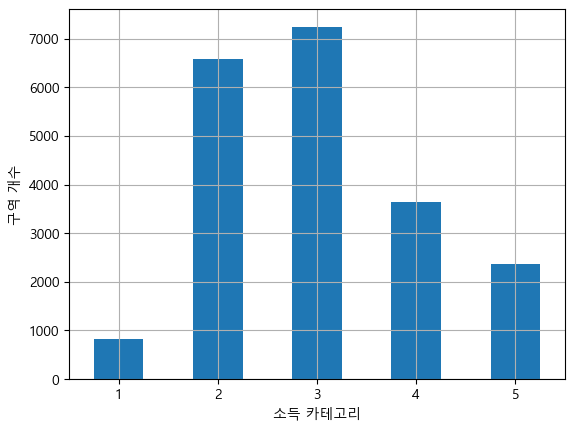

In [15]:
# 소득 카테고리 히스토그램
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("소득 카테고리")
plt.ylabel("구역 개수")
plt.show()

In [16]:
# dataset을 각각 다른 10개의 계층으로 분할
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)   # 10개의 train/test set을 생성
strat_splits = []   # 각각의 train/test set를 저장할 빈 리스트 생성
for train_index, test_index in splitter.split(housing, housing["income_cat"]):   # income_cat을 기준으로 데이터가 계층적/무작위로 분할 ... index 반환
    strat_train_set_n = housing.iloc[train_index]   # train set 생성
    strat_test_set_n = housing.iloc[test_index]   # test set 생
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [17]:
# 첫 번째 분할
strat_train_set, strat_test_set = strat_splits[0]

In [18]:
# train_test_split()의 stratify 매개변수 설정을 통한 계층적 샘플링
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [19]:
# income_cat feature은 사용하지 않으므로 삭제
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 4. 데이터 이해를 위한 탐색과 시각화

In [20]:
# 원본 데이터의 복사본 만들기
housing = strat_train_set.copy()

### 지리적 데이터 시각화하기

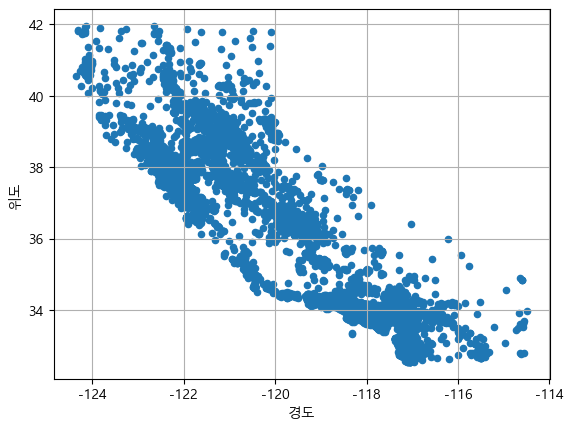

In [21]:
# 지리적 데이터 시각화하기 ... 지리 정보(위도&경도)가 포함되어 있으므로
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.xlabel("경도")
plt.ylabel("위도")
plt.show()

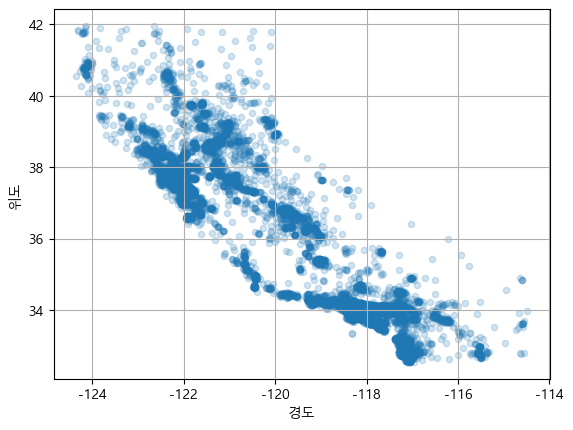

In [22]:
# alpha(투명도)를 추가하여 데이터 포인트가 밀집된 영역 보기
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.xlabel("경도")
plt.ylabel("위도")
plt.show()

-> 밀집된 지역이 눈에 더 잘 띔

<Axes: xlabel='longitude', ylabel='latitude'>

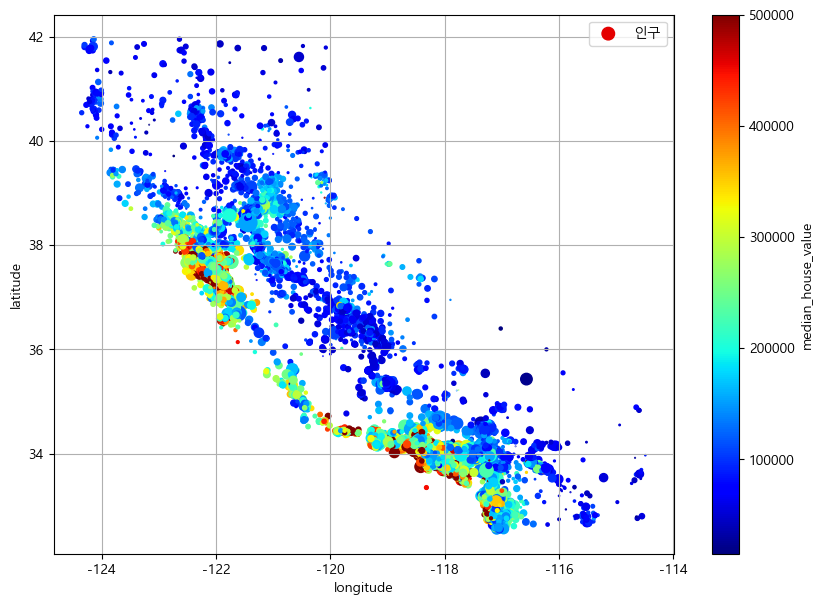

In [23]:
# + 주택 가격 나타내기
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"]/100, label="인구",   # s = 원의 반지름 -> 구역의 인구를 의미
             c="median_house_value", cmap="jet", colorbar=True,   # c = 색상 -> 가격을 의미
             legend=True, figsize=(10, 7))

-> 캘리포니아 주택 가격: 빨간색은 높은 가격, 파란색은 낮은 가격, 큰 원은 인구가 밀집된 지역을 나타냄

### 상관관계 조사하기

In [24]:
# 피어슨 표준 상관계수
corr_matrix = housing.corr(numeric_only=True)   # 숫자형 feature만 상관계수 계산

In [25]:
# 중간 주택 가격과 다른 특성 사이의 상관관계 확인
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

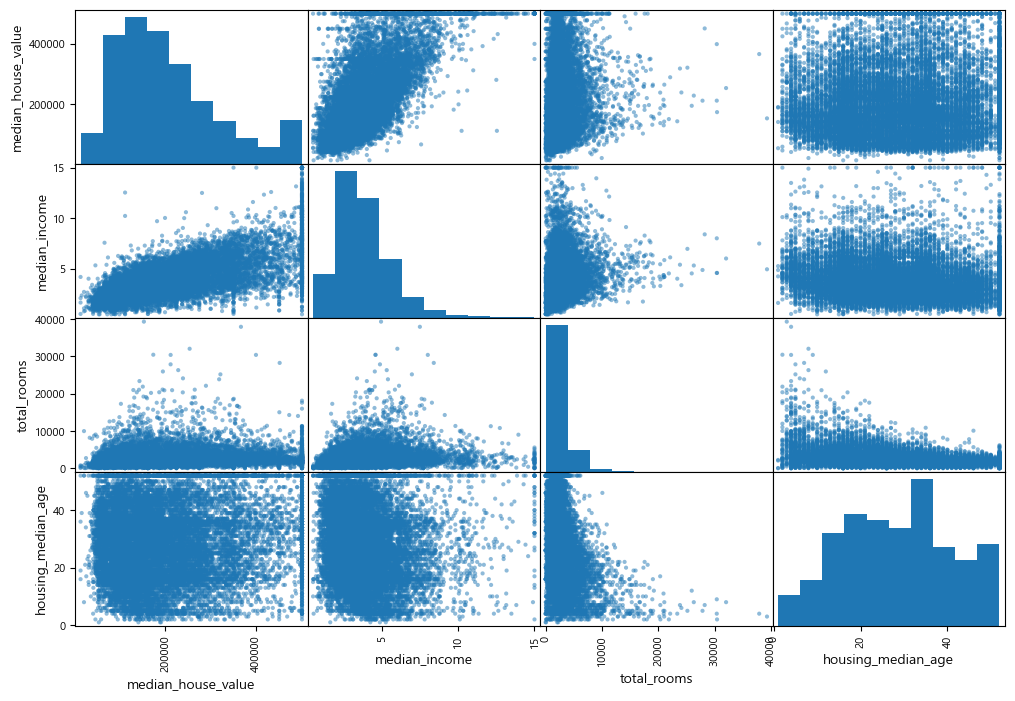

In [26]:
# scatter_matrix를 이용하여 숫자형 특성간 산점도 시각화
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

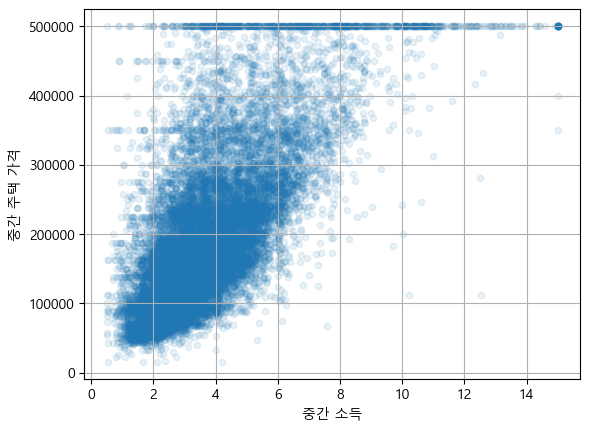

In [27]:
# 중간 주택 가격을 예측하는 데 가장 유용해 보이는 중간 소득과의 산점도 확대
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.xlabel("중간 소득")
plt.ylabel("중간 주택 가격")
plt.show()

### 특성 조합으로 실험하기
특성을 여러 가지로 조합하고 상관관계 확인

In [28]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_house"] = housing["population"] / housing["households"]

In [29]:
# 새로 만든 특성 상관관계 확인
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value      1.000000
median_income           0.688380
rooms_per_house         0.143663
total_rooms             0.137455
housing_median_age      0.102175
households              0.071426
total_bedrooms          0.054635
population             -0.020153
population_per_house   -0.038224
longitude              -0.050859
latitude               -0.139584
bedrooms_ratio         -0.256397
Name: median_house_value, dtype: float64

## 5. 머신러닝 알고리즘을 위한 데이터 준비

In [30]:
# 예측 변수와 레이블 분리
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### 데이터 정제

In [31]:
# # 결측치 처리 방법 3가지

# # 1. 해당 구역 제거
# housing.dropna(subset=["total_bedrooms"], inplace=True)

# # 2. 전체 특성 삭제
# housing.drop("total_bedrooms", axis=1, inplace=True)

# # 3. 결측값 채우기
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace=True)

In [32]:
# SimpleImputer 클래스를 이용하여 결측값 채우기
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")   # 결측치 -> 중간값으로 대체하도록 설정

In [33]:
# 수치형 특성만 가진 데이터 복사본 생성
housing_num = housing.select_dtypes(include=[np.number])

In [34]:
# 훈련 데이터에 적용
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [35]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

-> imputer는 각 특성의 중간값을 계산하여 그 결과를 객체의 statistics_ 속성에 저장

In [36]:
# 누락된 값을 학습한 중간값으로 변경
X = imputer.transform(housing_num)

In [37]:
# 넘파이 배열을 데이터프레임으로 변경
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

### 텍스트와 범주형 특성 다루기

In [38]:
# 텍스트 특성 살펴보기
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [39]:
# OrdinalEncoder 클래스를 이용하여 카테고리를  텍스트 -> 숫자로 변환 ... 순서가 있는 범주형 데이터를 숫자로 변환
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)   # 학습 후 변

In [40]:
# 인코딩된 값 확인
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [41]:
# 카테고리 리스트
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [42]:
# OneHotEncoder 클래스를 이용한 원-핫 인코딩(순서가 없는 카테고리를 해결하기 위해)
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [43]:
# 넘파이 배열로 바꾸기
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [44]:
# 카테고리 리스트
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [45]:
# get_dummies()를 이용해 원-핫 인코딩
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [46]:
df_test

,ocean_proximity
0,INLAND
1,NEAR BAY


In [47]:
# cat_encoder를 df_test에 적용
cat_encoder.transform(df_test)

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [48]:
# get_dummies()는 알 수 없는 카테고리도 변환된 결과를 출력
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [49]:
# OneHotEncoder handle_unknown = "ignore"를 통해 알 수 없는 카테고리를 0으로 나타내기
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

### 특성 스케일과 변환

In [50]:
# MinMaxScaler: min-max scaling ... 정규화
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))   # -1~1 범위로 scaling
housing_num_min_max_scaler = min_max_scaler.fit_transform(housing_num)

In [51]:
# StanrdScaler: 표준화
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [52]:
# rbf_kernel()을 이용하여 중간 주택 연도와 35사이의 유사도를 측정하는 가우스 RBF 특성 만들기
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

In [53]:
# inverse_transform: 역변환 (ex .. 로그값 -> 원본 scale로 변환)
from sklearn.linear_model import LinearRegression
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())   # series -> df로 변환
model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)   # 간단하게 만들기 위해 중간 소득으로 모델을 훈련
some_new_data = housing[["median_income"]].iloc[:5]   # 새로운 data로 가정
scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)   # 원본 scale로 변환

In [54]:
# TransformedTargetRegressor: 더 간단한 방법
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

### [참고]변환 파이프라인

In [55]:
# ClusterSimilarity 함수
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self   # 항상 self를 반환

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"클러스터 {i} 유사도" for i in range(self.n_clusters)]


In [56]:
# num_pipeline / cat_pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [57]:
# 모든 작업을 수행하는 pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]   # get_feature_names_out에 사용

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                           "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
], remainder=default_num_pipeline)   # 남은 특성: housing_median_age

In [58]:
# ColumnTransformer을 실행하여 모든 변환 수행
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

-> 24개의 feature를 가진 넘파이 배열 출력

## 6. 모델 선택과 훈련

### LinearRegression

In [59]:
# 선형 회귀 모델 훈련
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002592776ABD0>)])),
                ('linearregression', LinearRegression())])

In [60]:
# 5개의 예측 결과와 레이블 비교
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)   # -2 = 십의 자리에서 반올림

array([246000., 372700., 135700.,  91400., 330900.])

In [61]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [62]:
# 전체 훈련 set RMSE 측정
from sklearn.metrics import mean_squared_error
lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)

lin_rmse

C:\Users\lej55\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


68972.88910758485

### DecisionTreeRegressor

In [63]:
# DecisionTreeRegressor 모델 훈련
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002592776ABD0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [64]:
# 훈련 set로 예측 및 평가
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
tree_rmse

C:\Users\lej55\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.0

### 교차 검증: k-fold cross validation

In [65]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)   # 10-fold cross validation

In [66]:
# 결과
pd.Series(tree_rmses).describe()

count       10.000000
mean     67013.360949
std       1460.198570
min      64289.376198
25%      66776.146282
50%      67086.216281
75%      68140.275029
max      68659.294290
dtype: float64

### RandomForestRegressor

In [67]:
### RandomForestRegressor 모델 학습 및 교차 검증
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(n_estimators=20, random_state=42))   # 트리 수 20개로 설정
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

In [68]:
# 결과
pd.Series(forest_rmses).describe()

count       10.000000
mean     48082.337308
std       1131.790918
min      46335.654695
25%      47559.152638
50%      48163.393448
75%      48621.829383
max      50235.680207
dtype: float64